# FP Dual

This Jupyter Notebook includes all data processing. Twitter data are also available but including only User ID and Tweet ID, according to Twitter developer policy.

## Table of contents
- [0. Libraries](#0)
- [1. Preprocessing data](#1)
    * [1.1 Mentions](#11)
    * [1.2 Aggregate mentions](#12)
    * [1.3 Tweets frequencies](#13)
- [2. Descriptive statistics](#2)
    * [2.1 Tweets](#21)
    * [2.2 Mentions](#22)
    * [2.3 Twitter accounts](#23)
- [3. Evolution plots](#3)
- [4. Social network analysis](#4)
    * [4.1 Global](#41)
    * [4.2 First period (2011-2013)](#42)
    * [4.3 Second period (2014-2016)](#43)
    * [4.4 Third period (2017-2019)](#44)
- [5. Classification](#5)
    * [5.1 General](#51)
    * [5.2 Type 1 (Personal accounts)](#52)
    * [5.3 Type 2 (Institutional accounts)](#53)

## 0. Libraries <a name="0"></a>

In [1]:
require(dplyr)
require(ggplot2)
require(zoo)
require(igraph)
require(grid)
require(gridExtra)

source('functions.R')

set.seed(958)

# only for Jupyter
require(repr)
options(repr.plot.width=7, repr.plot.height=3)

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: grid
Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

  

## 1. Preprocessing data <a name="1"></a>

Data are divided in two datasets: tweets and mentions.

In [55]:
tweets <- read.csv2('data/tweets.csv', colClasses=c(tweet_id='character'), stringsAsFactors = FALSE)
mentions <- read.csv2('data/mentions.csv', colClasses=c(tweet_id='character'), stringsAsFactors = FALSE)
summary(tweets)
summary(mentions)

    author            tweet_id        
 Length:69025       Length:69025      
 Class :character   Class :character  
 Mode  :character   Mode  :character  

    author           mentioned           tweet_id        
 Length:55281       Length:55281       Length:55281      
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

In [56]:
all(mentions$tweet_id %in% tweets$tweet_id)
all(duplicated(tweets$tweet_id)==FALSE)

[1] TRUE

[1] TRUE

### 1.1 Mentions <a name="11"></a>

At first, mentions are transformed into a two-mode network and top actors are identified by degree, betweeness and eigenvector centrality indicators. 3% of network nodes are 413. We selected top 3% actor for each indicator.

In [57]:
edges_global <- mentions[, c('author', 'mentioned')]
edges_global$weight <- 1
edges_global <- dplyr::group_by(edges_global, author, mentioned)
edges_global <- dplyr::summarise(edges_global, weight=sum(weight))

In [58]:
top_actors <- top_network_nodes(edges_global, percen = 0.03)
top_actors$summary

413 top accounts


Warning message in igraph::eigen_centrality(g, directed = TRUE):
“At centrality.c:362 :Weighted directed graph in eigenvector centrality”

Indicators,Top,Cumulative,Accounts,Unique accounts
Degree,3,48.2,413,102
Betweeness,3,90.91,559,117
Eigenvector,3,87.46,788,229


### 1.2 Aggregate mentions <a name="12"></a>

Due to mentions dataset include one raw for each mention, grouping is required, counting repeated mentions.

In [59]:
mentions_unique <- mentions
mentions_unique$weight <- 1
mentions_unique <- dplyr::group_by(mentions_unique, author, date, tweet_id)
mentions_unique <- dplyr::summarise(mentions_unique, weight = sum(weight))

ERROR: Error: Column `date` is unknown


### 1.3 Tweets frequencies <a name="13"></a>

Finally, tweets and mentions frequencies are calculated by month and year.

In [7]:
freq_tweets <- full_freq_dates(tweets$date)
freq_mentions <- full_freq_dates(mentions_unique$date)

In [8]:
monthly_freq_tweets <- mon_ann_freq(freq_tweets, by='month')
monthly_freq_mentions <- mon_ann_freq(freq_mentions, by='month')

annual_freq_tweets <- mon_ann_freq(freq_tweets, by='annual')
annual_freq_mentions <- mon_ann_freq(freq_mentions, by='annual')

In [9]:
annual_freq_tweets

Dates,Freq
2011,85
2012,3123
2013,7136
2014,6832
2015,8867
2016,9314
2017,11699
2018,10933
2019,11036


## 2. Descriptive statistics <a name="2"></a>

### 2.1 Tweets <a name="21"></a>

There are 16,077 Twitter accounts discussing about FP Dual. They publish an average of 21,99 tweets per day, 663.7 per month, and 7669.44 per year.

In [10]:
length(table(tweets$author))

[1] 16077

In [11]:
basic_stats(freq_tweets$Freq)

Average 21.99 
SD 28.96 
Median 14 
Total 69025 


In [12]:
basic_stats(monthly_freq_tweets$Freq)

Average 663.7 
SD 401.01 
Median 649 
Total 69025 


In [13]:
basic_stats(annual_freq_tweets$Freq)

Average 7669.44 
SD 3897.76 
Median 8867 
Total 69025 


In [14]:
top_active_actors <- top_tweet(tweets[which(as.Date(tweets$date, format='%d-%m-%Y')<as.Date('01-01-2013', format='%d-%m-%Y')),'author'])[1:25,]
top_active_actors <- cbind(top_active_actors, top_tweet(tweets[which(as.Date(tweets$date, format='%d-%m-%Y')>=as.Date('01-01-2013', format='%d-%m-%Y')&
                            as.Date(tweets$date, format='%d-%m-%Y')<as.Date('01-01-2017', format='%d-%m-%Y')),'author'])[1:25,])
top_active_actors <- cbind(top_active_actors,
                           top_tweet(tweets[which(as.Date(tweets$date, format='%d-%m-%Y')>=as.Date('01-01-2017', format='%d-%m-%Y')),'author'])[1:25,])

In [16]:
top_active_actors

Account,Tweets,Account,Tweets,Account,Tweets
aarranzcad,45,FBertelsmann,1964,Alianzafpdual,983
olgaamarti,45,TrabajosCCC,677,FBertelsmann,885
Isabel_Gonzal,38,francescdg,486,DualizaBankia,425
LolaPSageras,30,Alianzafpdual,340,AnicetoRamirez,334
malonsorosa,29,PortalAlemania,256,TeideHease,333
formagrupo,27,Magisnet,149,Guadalupbragado,266
portalparados,23,casacochecurro,147,IgnaciodeBenito,255
orientaedu,22,JaviNavarro1,147,camarascomercio,245
FAPARioja,19,Isabel_Gonzal,135,FPactual,245
aalmarazmar,16,Paloma_Donaire,132,AHK_es,220


### 2.2 Mentions <a name="22"></a>

There are 8001 Twitter accounts that realise mentions. Twitter accounts publish an average of 9,77 tweets with mentions per day, 294.97 per month, and 3408.56 per year.

In [17]:
length(table(mentions_unique$author))

[1] 8001

In [18]:
basic_stats(freq_mentions$Freq)

Average 9.77 
SD 14.34 
Median 5 
Total 30677 


In [19]:
basic_stats(monthly_freq_mentions$Freq)

Average 294.97 
SD 219.74 
Median 253.5 
Total 30677 


In [20]:
basic_stats(annual_freq_mentions$Freq)

Average 3408.56 
SD 2267.74 
Median 3146 
Total 30677 


In [21]:
top_mentioned_actors <- top_mentioned(mentions[which(as.Date(mentions$date, format='%d-%m-%Y')<as.Date('01-01-2013', format='%d-%m-%Y')),'mentioned'])[1:25,]
top_mentioned_actors <- cbind(top_mentioned_actors, top_mentioned(mentions[which(as.Date(mentions$date, format='%d-%m-%Y')>=as.Date('01-01-2013', format='%d-%m-%Y')&
                                                                                 as.Date(mentions$date, format='%d-%m-%Y')<as.Date('01-01-2017', format='%d-%m-%Y')),'mentioned'])[1:25,])
top_mentioned_actors <- cbind(top_mentioned_actors,
                           top_mentioned(mentions[which(as.Date(mentions$date, format='%d-%m-%Y')>=as.Date('01-01-2017', format='%d-%m-%Y')),'mentioned'])[1:25,])

In [22]:
top_mentioned_actors

Account,Mentions,Account,Mentions,Account,Mentions
libertaddigital,50,FBertelsmann,770,Alianzafpdual,1803
LaVanguardia,36,Alianzafpdual,462,FBertelsmann,1765
elmundoes,35,Bankia,320,FPAndaluza,650
europapress_es,34,el_pais,248,DualizaBankia,531
Isabel_Gonzal,32,abc_es,171,Bankia,528
abc_es,30,marianorajoy,167,elmundoes,421
AmadeoMora,23,Magisnet,162,CincoDiascom,412
20m,20,ComunidadMadrid,160,EducaAnd,395
Jiwert,20,jcyl,151,educaciongob,358
La_SER,17,FPeuskadi,125,FPeuskadi,310


### 2.3 Twitter accounts <a name="23"></a>

Each Twitter account publish 4.29 tweets and realise 3.83 mentions (tweets with one or more mentions) on average.

In [23]:
basic_stats(as.integer(table(tweets$author)))

Average 4.29 
SD 29.02 
Median 1 
Total 69025 


In [24]:
basic_stats(as.integer(table(mentions_unique$author)))

Average 3.83 
SD 22.59 
Median 1 
Total 30677 


## 3. Evolution plots <a name="3"></a>

At first we obtain the timeline of tweets by day.

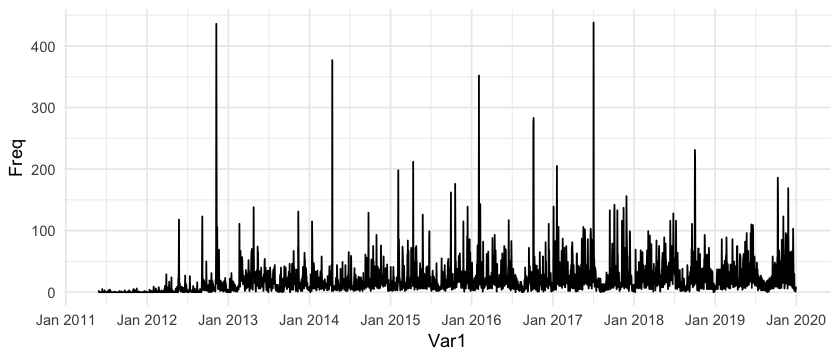

In [25]:
ggplot2::ggplot() +
  ggplot2::geom_line(data=freq_tweets, ggplot2::aes(y=Freq, x=Var1)) +
  ggplot2::scale_x_date(date_labels = '%b %Y', date_breaks = '1 year') +
  ggplot2::theme_minimal()

Annual and monthly evolution, between 2012 and 2020, are obtained, tagging the most relevant bursts of tweets.

In [26]:
peaks <- read.delim('data/peaks.tsv', stringsAsFactors=FALSE)
peaks$Pos <- 1:dim(peaks)[1]
peaks$Date <- zoo::as.Date(peaks$Date, format='%d-%m-%Y')
peaks$Type[which(peaks$Type=='Eventos de fundaciones\\ny otros acontecimientos')] <- 'Eventos de fundaciones\ny otros acontecimientos'

Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 7 rows containing missing values (position_stack).”Warning message:
“Removed 7 rows containing missing values (position_stack).”Warning message:
“Removed 7 rows containing missing values (geom_path).”Warning message:
“Removed 7 rows containing missing values (geom_path).”

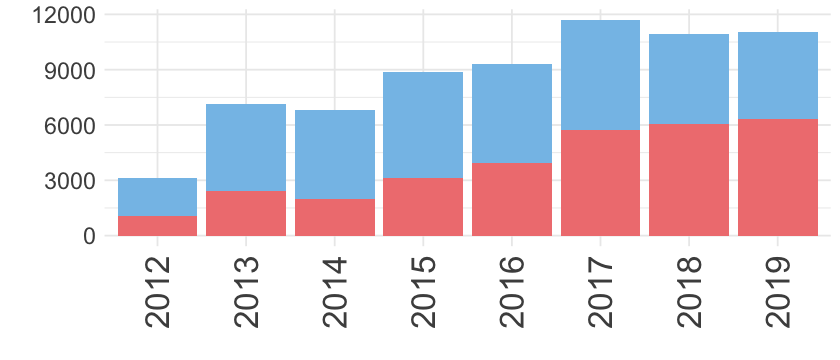

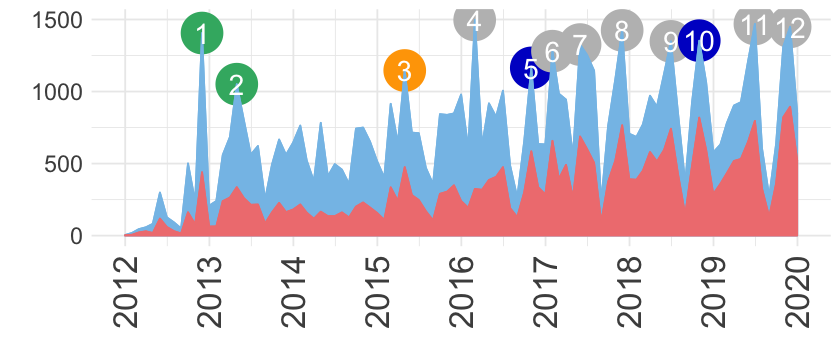

In [27]:
#png('figures/annual_evolution.png', height = 2000, width = 2500, res = 300)
ggplot() +
  geom_col(data=annual_freq_tweets, aes(y=Freq, x=Dates), fill = '#85C1E9') +
  geom_col(data=annual_freq_mentions, aes(y=Freq, x=Dates), fill = '#F08080') +
  labs(x='', y='') +
  xlim(as.character(2012:2019)) +
  theme_minimal() +
  theme(legend.position = 'none',
       axis.text.x = element_text(angle = 90, size = 20, hjust=.95, vjust=0.5),
       axis.text.y = element_text(size = 14))
#dev.off()

#png('figures/monthly_evolution.png', height = 2000, width = 2500, res = 300)
ggplot() +
  geom_point(data=peaks, aes(y=Value, x=Date, colour=Type), size = 18, stroke=0, shape=20) +
  geom_line(data=monthly_freq_tweets, aes(y=Freq, x=Dates, colour = 'Total')) +
  geom_area(data=monthly_freq_tweets, aes(y=Freq, x=Dates), fill='#85C1E9', colour='#85C1E9') +
  geom_line(data=monthly_freq_mentions, aes(y=Freq, x=Dates, colour = 'Mentions')) +
  geom_area(data=monthly_freq_mentions, aes(y=Freq, x=Dates), fill='#F08080', colour='#F08080') +
  geom_text(data=peaks, aes(y=Value, x=Date, label=Pos), size=6, color='white', show.legend = FALSE) +
  scale_colour_manual('', 
                      breaks = c('Total', 'Mentions', 'Normativas', 'Noticias de prensa', 'Eventos de fundaciones', 'Eventos de fundaciones\ny otros acontecimientos'),
                      values = c('Total'='#85C1E9', 'Mentions'='#F08080',
                                 'Normativas'='#3CB371', 'Noticias de prensa'='orange',
                                 'Eventos de fundaciones'='#0000cc', 'Eventos de fundaciones\ny otros acontecimientos'='grey'),
                      guide = guide_legend(override.aes = list(
                          linetype = c('solid','solid', 'blank', 'blank', 'blank', 'blank'),
                          shape = c(NA, NA, 21, 21, 21, 21)))
                     ) +
  scale_x_date(date_labels = "%Y", date_breaks = '1 year', limit=c(as.Date('2011-12-31', format='%Y-%m-%d'),max(monthly_freq_tweets$Dates))) +
  labs(x='', y='') +
  theme_minimal() +
  theme(legend.position='none',
       axis.text.x = element_text(angle = 90, size = 20, hjust=.95, vjust=0.5),
       axis.text.y = element_text(size = 14))
#dev.off()

## 4. Social network analysis <a name="4"></a>

Four co-mentions networks are obtained: global and one per studied period.

### 4.1 First period (2011-2013) <a name="41"></a>

In this period there are 1636 active actors, 668 actors that realise at least one mention, 464 actors mentioned, and a total of 1904 actors.

In [28]:
first_period_tweets <- tweets[which(as.Date(tweets$date, format='%d-%m-%Y')<as.Date('01-01-2013', format='%d-%m-%Y')),]

first_period_mentions <- mentions[which(as.Date(mentions$date, format='%d-%m-%Y')<as.Date('01-01-2013', format='%d-%m-%Y')),]
first_period <- co_mentions(first_period_mentions)

period_stats(first_period_tweets, first_period_mentions)

Active actors: 1636 
Active mentions: 668 
Mentions actors: 464 
Mentions: 1321 
Total actors: 1904 


In [36]:
head(first_period_tweets[order(first_period_tweets$replies, decreasing = TRUE), c('author', 'tweet', 'replies')], n=25)

,author,tweet,replies
2560,Jiwert,"En Stuttgart, Alemania, visitando el centro de FP Mercedes Benz para conocer más detalles de la FP dual",137
81,EsperanzAguirre,"Implantaremos un sistema de FP dual, inspirado en el alemán: combina la formación en el centro educativo con el trabajo ya en una empresa.",35
1287,La_SER,"Wert sobre la FP dual: Pueden recibir una beca salario a cargo de la administración, de la empresa o de los dos http://ow.ly/f86ql Wert sobre la FP dual: Pueden recibir una beca salario a cargo de la administración, de la empresa o de los dos http://ow.ly/f86ql",7
2833,populares,El Gobierno impulsa un modelo de FP Dual para permitir que los alumnos puedan formarse y trabajar al mismo tiempo http://www.pp.es/actualidad-noticia/jovenes-podran-combinar-su-formacion-practicas-remuneradas-empresas_6411.html,6
890,jarevalo_FP,"@iElenaR: Ejemplos de la FP Dual a la española,para echarse a llorar: http://bit.ly/SUNOyh http://bit.ly/SUNNKJ vía @Isabel_Gonzal @angeldp @iElenaR: Ejemplos de la FP Dual a la española,para echarse a llorar: http://bit.ly/SUNOyh http://bit.ly/SUNNKJ vía @Isabel_Gonzal @angeldp",5
296,GVAeducacio,Martí: La Comunitat es pionera en la puesta en marcha de la FP dual al contar con 14 centros que la imparten este... http://www.cefe.gva.es/agenda.asp?id=920 Martí: La Comunitat es pionera en la puesta en marcha de la FP dual al contar con 14 centros que la imparten este... http://www.cefe.gva.es/agenda.asp?id=920,4
1095,Isabel_Gonzal,Leyendo blog de alumno en el que explica las condiciones en las que ha realizado las prácticas #FPDual Explotación? http://vivoenunmundodelocos.wordpress.com/2012/10/03/practicas-de-fp-dual-en-el-hotel-nh-las-condiciones-de-una-explotacion-legal-y-sin-convenio/,4
2757,SIGMA_AIE,Joan Busquiel: invito a las empresas qu prueben el modelo del learning center #FPdual Joan Busquiel: invito a las empresas qu prueben el modelo del learning center #FPdual,4
102,yolajb,"@angeldelallave ¿FP dual? cuenta, cuenta, ... http://latinareverde.wordpress.com/2012/12/19/fp-dual/ #mareaverde",3
485,MiguelGTormo,Suiza: la FP dual que Wert quiere imitar. Deberíamos imitarles en muchas cosas más... http://www.libremercado.com/2012-11-18/la-fp-dual-que-wert-quiere-imitar-las-claves-del-exito-de-suiza-1276474493/,3


In [37]:
head(first_period_tweets[order(first_period_tweets$favs, decreasing = TRUE), c('author', 'tweet', 'favs')], n=25)

,author,tweet,favs
2560,Jiwert,"En Stuttgart, Alemania, visitando el centro de FP Mercedes Benz para conocer más detalles de la FP dual",28
1821,Isabel_Gonzal,"Nuevo blog, punto de encuentro de afectados, de una profesora sobre el caos en la #FPDual http://fpdual.wordpress.com/opinion-y-reflexiones/",5
1284,gomezdelpozuelo,Plan de empleo para los jóvenes: el Gobierno creará un Contrato para la Formación y Aprendizaje y la FP Dual http://ow.ly/f8n0n,4
1390,ElSaltoDiario,"El #CMin ha aprobado hoy la FP dual, una vía de iniciación a la precariedad que ya explicamos por aquí: http://www.diagonalperiodico.net/Iniciacion-a-la-precariedad.html",4
1758,democraciareal,"FP Dual, o como explotar al alumando por 450 euros por @soypublica http://bit.ly/RtGNBm #15m",4
81,EsperanzAguirre,"Implantaremos un sistema de FP dual, inspirado en el alemán: combina la formación en el centro educativo con el trabajo ya en una empresa.",3
85,m_angelmendez,¿Cómo combatir el 45% de paro juvenil en España? Una clave: con el modelo alemán de FP dual http://bit.ly/iVM2fh,3
1039,Isabel_Gonzal,Real Decreto 1529/2012 #FPdual y desarrollo contrato formación y aprendizaje. Enlace al #BOE http://www.boe.es/boe/dias/2012/11/09/pdfs/BOE-A-2012-13846.pdf,3
1087,Isabel_Gonzal,A los profesores d FP nos preocupan las consecuencias d la puesta en marcha #FPDual. Blog de una profesora http://fpdual.wordpress.com/,3
1168,erojotorrecilla,"RD 1529/2012, 8.11. Desarrolla el contrato para la formación y el aprend. Establece bases de la FP dual. http://bit.ly/RM0wwH ¡A estudiar!",3


In [38]:
head(first_period_tweets[order(first_period_tweets$retweets, decreasing = TRUE), c('author', 'tweet', 'retweets')], n=20)

,author,tweet,retweets
2560,Jiwert,"En Stuttgart, Alemania, visitando el centro de FP Mercedes Benz para conocer más detalles de la FP dual",54
81,EsperanzAguirre,"Implantaremos un sistema de FP dual, inspirado en el alemán: combina la formación en el centro educativo con el trabajo ya en una empresa.",34
2833,populares,El Gobierno impulsa un modelo de FP Dual para permitir que los alumnos puedan formarse y trabajar al mismo tiempo http://www.pp.es/actualidad-noticia/jovenes-podran-combinar-su-formacion-practicas-remuneradas-empresas_6411.html,28
1095,Isabel_Gonzal,Leyendo blog de alumno en el que explica las condiciones en las que ha realizado las prácticas #FPDual Explotación? http://vivoenunmundodelocos.wordpress.com/2012/10/03/practicas-de-fp-dual-en-el-hotel-nh-las-condiciones-de-una-explotacion-legal-y-sin-convenio/,21
1390,ElSaltoDiario,"El #CMin ha aprobado hoy la FP dual, una vía de iniciación a la precariedad que ya explicamos por aquí: http://www.diagonalperiodico.net/Iniciacion-a-la-precariedad.html",20
1452,A3Noticias,DIRECTO: El Consejo de ministros reduce el parque móvil y aprueba el programa de FP Dual http://www.antena3.com/noticias/economia/_2012110800012.html,19
1380,expansioncom,La nueva FP dual combinará estudio y empleo http://www.expansion.com/2012/11/08/entorno/1352386943.html vía @expansioncom,17
1295,iunida,IU denuncia que el nuevo decretazo de Wert sobre la FP dual se vuelve a imponer de espaldas a la comunidad educativa http://www.izquierda-unida.es/node/11430,16
1758,democraciareal,"FP Dual, o como explotar al alumando por 450 euros por @soypublica http://bit.ly/RtGNBm #15m",16
1201,larazon_es,"El Consejo de Ministros da luz verde a la FP dual, más profesional y vinculada a la empresa http://bit.ly/SUd4oh #educación",15


In [ ]:
#write.csv2(first_period, 'Maps/first_period.csv',
#          row.names=FALSE)

### 4.2 Second period (2014-2016) <a name="42"></a>

In this period there are 8698 active actors, 3777 actors that realise at least one mention, 3276 actors mentioned, and a total of 10582 actors.

In [39]:
second_period_tweets <- tweets[which(as.Date(tweets$date, format='%d-%m-%Y')>=as.Date('01-01-2013', format='%d-%m-%Y')&
                                     as.Date(tweets$date, format='%d-%m-%Y')<as.Date('01-01-2017', format='%d-%m-%Y')),]

second_period_mentions <- mentions[which(as.Date(mentions$date, format='%d-%m-%Y')>=as.Date('01-01-2013', format='%d-%m-%Y')&
                                         as.Date(mentions$date, format='%d-%m-%Y')<as.Date('01-01-2017', format='%d-%m-%Y')),]
second_period <- co_mentions(second_period_mentions)

period_stats(second_period_tweets, second_period_mentions)

Active actors: 8698 
Active mentions: 3777 
Mentions actors: 3276 
Mentions: 16625 
Total actors: 10582 


In [40]:
head(second_period_tweets[order(second_period_tweets$replies, decreasing = TRUE), c('author', 'tweet', 'replies')], n=25)

,author,tweet,replies
30923,pablocasado_,"Hay que seguir creando empleo, mantener el estado de bienestar, apostar por la innovación y la FP dual con el @PPopular #RajoyenSalvados",88
3963,marianorajoy,"Medidas para impulsar el empleo juvenil: contrato para la formación y el aprendizaje, FP Dual, incentivos fiscales y #EEEJ #SesióndeControl",36
9972,marianorajoy,"Una ambiciosa reforma educativa, FP Dual y Contrato de Formación y Aprendizaje, oportunidades para el empleo joven #DEN2013",36
26152,marianorajoy,La Formación Profesional y la FP Dual son imprescindibles si queremos hacer de #España un país a la vanguardia. Esta apuesta es de éxito,32
34202,Nestle_es,Por nuestro centro de La Penilla han pasado 71 estudiantes del Programa #FPDual y 23 han firmado contrato con Nestlé http://bddy.me/2eXkvKP,27
23567,populares,".@pablocasado_ Mucho de lo que propone Ciudadanos en Educación ya lo ha hecho el PP, como en materia de FP dual http://www.cumpplimos.es/educacion-camino-de-oportunidades/formacion-profesional-para-el-empleo/",20
23752,sanchezcastejon,"Hay que abrir espacios de diálogo entre los trabajadores y empresarios, y apostar por la FP dual y la I+D+I",20
19852,populares,Fomentamos la FP Dual @marianorajoy #CaraACaraL6 #YoVotoPP,17
31653,SextaNocheTV,.@pablocasado_ Hemos propuesto ir a una FP dual y una Universidad en la que oferta y demanda casen #L6Ncasado,16
20222,mdcospedal,El mejor plan de empleo joven y la mejor garantía de creación de empleo será el plan nacional de FP dual del PP,15


In [42]:
head(second_period_tweets[order(second_period_tweets$favs, decreasing = TRUE), c('author', 'tweet', 'favs')], n=25)

,author,tweet,favs
34202,Nestle_es,Por nuestro centro de La Penilla han pasado 71 estudiantes del Programa #FPDual y 23 han firmado contrato con Nestlé http://bddy.me/2eXkvKP,415
30923,pablocasado_,"Hay que seguir creando empleo, mantener el estado de bienestar, apostar por la innovación y la FP dual con el @PPopular #RajoyenSalvados",245
31597,fundacionexit,El 47% de los jóvenes de la 1ª Ed. de #FPDual con @Desigual_ES @ensenyamentcat ha sido contratado #eDuoExit #Talento,121
19852,populares,Fomentamos la FP Dual @marianorajoy #CaraACaraL6 #YoVotoPP,120
26152,marianorajoy,La Formación Profesional y la FP Dual son imprescindibles si queremos hacer de #España un país a la vanguardia. Esta apuesta es de éxito,103
22826,gradosuperior,La FP dual crecera en Catalunya http://www.fpgradosuperior.es/noticias/fp-dual-crecera-catalunya/,97
34259,iescolar,Los buenísimos resultados de la FP dual de la que presume Rajoy en realidad fueron un fiasco: http://buff.ly/2evCOJ3,91
26902,JavierMaroto,"Más FP dual, más becas en la Universidad, más impulso al inglés y más reconocimiento a los docentes #RutaSocial",86
23752,sanchezcastejon,"Hay que abrir espacios de diálogo entre los trabajadores y empresarios, y apostar por la FP dual y la I+D+I",85
32632,populares,Alcanzaremos las 100.000 plazas de FP Dual #26Medidas26J,78


In [43]:
head(second_period_tweets[order(second_period_tweets$retweets, decreasing = TRUE), c('author', 'tweet', 'retweets')], n=25)

,author,tweet,retweets
30923,pablocasado_,"Hay que seguir creando empleo, mantener el estado de bienestar, apostar por la innovación y la FP dual con el @PPopular #RajoyenSalvados",473
19852,populares,Fomentamos la FP Dual @marianorajoy #CaraACaraL6 #YoVotoPP,309
32632,populares,Alcanzaremos las 100.000 plazas de FP Dual #26Medidas26J,188
34259,iescolar,Los buenísimos resultados de la FP dual de la que presume Rajoy en realidad fueron un fiasco: http://buff.ly/2evCOJ3,182
23752,sanchezcastejon,"Hay que abrir espacios de diálogo entre los trabajadores y empresarios, y apostar por la FP dual y la I+D+I",146
26152,marianorajoy,La Formación Profesional y la FP Dual son imprescindibles si queremos hacer de #España un país a la vanguardia. Esta apuesta es de éxito,146
26902,JavierMaroto,"Más FP dual, más becas en la Universidad, más impulso al inglés y más reconocimiento a los docentes #RutaSocial",131
23567,populares,".@pablocasado_ Mucho de lo que propone Ciudadanos en Educación ya lo ha hecho el PP, como en materia de FP dual http://www.cumpplimos.es/educacion-camino-de-oportunidades/formacion-profesional-para-el-empleo/",119
20222,mdcospedal,El mejor plan de empleo joven y la mejor garantía de creación de empleo será el plan nacional de FP dual del PP,99
34202,Nestle_es,Por nuestro centro de La Penilla han pasado 71 estudiantes del Programa #FPDual y 23 han firmado contrato con Nestlé http://bddy.me/2eXkvKP,95


Until this period there are 9708 active actors, 4216 actors that realise at least one mention, 3534 actors mentioned, and a total of 11712 actors.

In [ ]:
period_stats(rbind(first_period_tweets, second_period_tweets), rbind(first_period_mentions, second_period_mentions))

In [ ]:
#write.csv2(second_period, 'Maps/second_period.csv',
#          row.names=FALSE)

### 4.3 Third period (2017-2019) <a name="43"></a>

In this period there are 8410 active actors, 4702 actors that realise at least one mention, 5859 actors mentioned, and a total of 12172 actors.

In [44]:
third_period_tweets <- tweets[which(as.Date(tweets$date, format='%d-%m-%Y')>=as.Date('01-01-2017', format='%d-%m-%Y')),]

third_period_mentions <- mentions[which(as.Date(mentions$date, format='%d-%m-%Y')>=as.Date('01-01-2017', format='%d-%m-%Y')),]
third_period <- co_mentions(third_period_mentions)


period_stats(third_period_tweets, third_period_mentions)

Active actors: 8410 
Active mentions: 4702 
Mentions actors: 5859 
Mentions: 37335 
Total actors: 12172 


In [45]:
head(third_period_tweets[order(third_period_tweets$replies, decreasing = TRUE), c('author', 'tweet', 'replies')], n=25)

,author,tweet,replies
63330,pablocasado_,"Decálogo Educación: 🔹Libertad de elección 🔹Evaluación pública de conocimiento 🔹El castellano lengua vehicular 🔹Inspección adoctrinamiento 🔹Materias troncales comunes 🔹Bilingüismo inglés 🔹Educación concertada, especial y rural 🔹MIR educativo 🔹FP dual 🔹Escolarización 0-3",813
57354,sanchezcastejon,El Gobierno avanza hacia la creación de un país justo e innovador. Lo hace fomentando el ecosistema de los #emprendedores tecnológicos. Con una FP Dual transformadora. Elaboraremos una Ley de #startups que reconozca sus singularidades y fomente su desarrollo.👇🏼#SouthSummit2018,661
64380,pablocasado_,"En las CC. AA. donde gobernemos: 🔹Gratuidad progresiva Educación 0-3 años 🔹Libertad de elección de colegio 🔹Garantizamos la educación concertada, especial y ámbito rural 🔹Bachillerato concertado 🔹Fin de los barracones 🔹Bilingüismo en inglés 🔹FP dual #CentradosEnTuFuturo",178
67604,pablocasado_,Nuestro decálogo en Educación 🔹Libertad de elección de colegio 🔹Evaluación pública nacional 🔹Contenido común en toda España 🔹Inspección adoctrinamiento 🔹Castellano lengua vehicular 🔹Bilingüismo en inglés 🔹Asignaturas digitales 🔹MIR educativo 🔹Escolarización 0-3 🔹FP dual,178
62934,pablocasado_,"Para mejorar el empleo proponemos 🔹“Mochila austriaca”. El trabajador dispondrá de sus cotizaciones 👉si cambia de trabajo 👉o residencia 👉o despido 👉o cuando se jubila 🔹Bono FP dual - 430€ año compatible con el salario 🔹Bono formación, para la libre elección de los parados",148
49525,populares,👉 @pablocasado_ recuerda que con el Partido Popular logramos: 🔵 Los dos milagros económicos 🔵 Récord de inversión en becas 🔵 Tarifa plana de autónomos de hasta dos años 🔵 Fomento de la FP Dual 🔵 Saneamiento de la banca 🔵 Los mejores servicios sociales #GarantíaDeCambio,135
51013,pablocasado_,"🔵Desde que gobierna el @PPopular se han creado 2 mill de empleos, se ha bajado el paro Juvenil un 20% y más de 800.000 jóvenes cursan la FP dual. Pero es imprescindible desbloquear la LOMCE para potenciar las materias más demandadas en el nuevo mercado laboral #EscuelaDeInvierno",73
64257,populares,"⏯ @pablocasado_: En las Comunidades del PP, eligen las familias el tipo de Educación que quieren para sus hijos, no un código postal ni un político. Apostamos: ☝️Por una educación en libertad ☝️Por una educación bilingüe ☝️Por la FP dual #CentradosEnTuFuturo @pablocasado_: En las Comunidades del PP, eligen las familias el tipo de Educación que quieren para sus hijos, no un código postal ni un político. Apostamos: Por una educación en libertad Por una educación bilingüe Por la FP dual #CentradosEnTuFuturo",67
61739,pablocasado_,Mi compromiso con el sector del automóvil 👇 🚗 Defender a los 16 millones de conductores del diésel y a los fabricantes 🔧 Impulso a la FP dual para luchar contra el paro juvenil 📈 I+d+i ⬇️ Tributación beneficiosa para la compra de vehículos eléctricos 🔝 Puntos de recarga,58
58599,IdiazAyuso,-Libertad elección enseñanza. -Bachillerado concertado/ Internacional. -FP Dual. A mí hay aspectos de la Ley de Violencia de Género que no me gustan. No creo que los hombres y mujeres seamos culpables o víctimas por razón de sexo. Pero no puede ser una línea roja para el cambio.,50


In [46]:
head(third_period_tweets[order(third_period_tweets$favs, decreasing = TRUE), c('author', 'tweet', 'favs')], n=25)

,author,tweet,favs
63330,pablocasado_,"Decálogo Educación: 🔹Libertad de elección 🔹Evaluación pública de conocimiento 🔹El castellano lengua vehicular 🔹Inspección adoctrinamiento 🔹Materias troncales comunes 🔹Bilingüismo inglés 🔹Educación concertada, especial y rural 🔹MIR educativo 🔹FP dual 🔹Escolarización 0-3",2022
57354,sanchezcastejon,El Gobierno avanza hacia la creación de un país justo e innovador. Lo hace fomentando el ecosistema de los #emprendedores tecnológicos. Con una FP Dual transformadora. Elaboraremos una Ley de #startups que reconozca sus singularidades y fomente su desarrollo.👇🏼#SouthSummit2018,1076
56558,siemens_ind,"☝¿Eres estudiante o profesor de #automatización industrial? ¡Te ayudamos a mejorar! En #SiemensSCE, te ofrecemos: ▪Cursos ▪Documentación didáctica ▪Concurso ▪Manuales ¡Echa un vistazo! https://sie.ag/2Q9dyso #industria40 #digitalizacion #FP #FPDual",823
60738,populares,¿Qué proponemos en materia educativa?👨‍🎓🏫 - Cheque para la FP dual - MIR Educativo a nivel nacional - Evaluación de conocimientos estatal - Bilingüismo también en la pública y concertada - Libertad de elección de colegio y del modelo educativo para los padres #ElDebate4N,694
50292,siemens_es,#Empleo | Estamos buscando #talento para estas vacantes: ▪️ Ingeniera/o de mejora de procesos (#Madrid) ▪️ #FPDual Técnica en Mecatrónica (#España / #Alemania) ▪️ Técnico CNC (#Zamudio) Apúntate: http://sie.ag/2AVGMTZ #soySiemens,597
62934,pablocasado_,"Para mejorar el empleo proponemos 🔹“Mochila austriaca”. El trabajador dispondrá de sus cotizaciones 👉si cambia de trabajo 👉o residencia 👉o despido 👉o cuando se jubila 🔹Bono FP dual - 430€ año compatible con el salario 🔹Bono formación, para la libre elección de los parados",549
64380,pablocasado_,"En las CC. AA. donde gobernemos: 🔹Gratuidad progresiva Educación 0-3 años 🔹Libertad de elección de colegio 🔹Garantizamos la educación concertada, especial y ámbito rural 🔹Bachillerato concertado 🔹Fin de los barracones 🔹Bilingüismo en inglés 🔹FP dual #CentradosEnTuFuturo",516
67604,pablocasado_,Nuestro decálogo en Educación 🔹Libertad de elección de colegio 🔹Evaluación pública nacional 🔹Contenido común en toda España 🔹Inspección adoctrinamiento 🔹Castellano lengua vehicular 🔹Bilingüismo en inglés 🔹Asignaturas digitales 🔹MIR educativo 🔹Escolarización 0-3 🔹FP dual,486
61739,pablocasado_,Mi compromiso con el sector del automóvil 👇 🚗 Defender a los 16 millones de conductores del diésel y a los fabricantes 🔧 Impulso a la FP dual para luchar contra el paro juvenil 📈 I+d+i ⬇️ Tributación beneficiosa para la compra de vehículos eléctricos 🔝 Puntos de recarga,426
49525,populares,👉 @pablocasado_ recuerda que con el Partido Popular logramos: 🔵 Los dos milagros económicos 🔵 Récord de inversión en becas 🔵 Tarifa plana de autónomos de hasta dos años 🔵 Fomento de la FP Dual 🔵 Saneamiento de la banca 🔵 Los mejores servicios sociales #GarantíaDeCambio,313


In [47]:
head(third_period_tweets[order(third_period_tweets$retweets, decreasing = TRUE), c('author', 'tweet', 'retweets')], n=25)

,author,tweet,retweets
63330,pablocasado_,"Decálogo Educación: 🔹Libertad de elección 🔹Evaluación pública de conocimiento 🔹El castellano lengua vehicular 🔹Inspección adoctrinamiento 🔹Materias troncales comunes 🔹Bilingüismo inglés 🔹Educación concertada, especial y rural 🔹MIR educativo 🔹FP dual 🔹Escolarización 0-3",983
60738,populares,¿Qué proponemos en materia educativa?👨‍🎓🏫 - Cheque para la FP dual - MIR Educativo a nivel nacional - Evaluación de conocimientos estatal - Bilingüismo también en la pública y concertada - Libertad de elección de colegio y del modelo educativo para los padres #ElDebate4N,556
57354,sanchezcastejon,El Gobierno avanza hacia la creación de un país justo e innovador. Lo hace fomentando el ecosistema de los #emprendedores tecnológicos. Con una FP Dual transformadora. Elaboraremos una Ley de #startups que reconozca sus singularidades y fomente su desarrollo.👇🏼#SouthSummit2018,507
62934,pablocasado_,"Para mejorar el empleo proponemos 🔹“Mochila austriaca”. El trabajador dispondrá de sus cotizaciones 👉si cambia de trabajo 👉o residencia 👉o despido 👉o cuando se jubila 🔹Bono FP dual - 430€ año compatible con el salario 🔹Bono formación, para la libre elección de los parados",344
61739,pablocasado_,Mi compromiso con el sector del automóvil 👇 🚗 Defender a los 16 millones de conductores del diésel y a los fabricantes 🔧 Impulso a la FP dual para luchar contra el paro juvenil 📈 I+d+i ⬇️ Tributación beneficiosa para la compra de vehículos eléctricos 🔝 Puntos de recarga,261
64380,pablocasado_,"En las CC. AA. donde gobernemos: 🔹Gratuidad progresiva Educación 0-3 años 🔹Libertad de elección de colegio 🔹Garantizamos la educación concertada, especial y ámbito rural 🔹Bachillerato concertado 🔹Fin de los barracones 🔹Bilingüismo en inglés 🔹FP dual #CentradosEnTuFuturo",253
67604,pablocasado_,Nuestro decálogo en Educación 🔹Libertad de elección de colegio 🔹Evaluación pública nacional 🔹Contenido común en toda España 🔹Inspección adoctrinamiento 🔹Castellano lengua vehicular 🔹Bilingüismo en inglés 🔹Asignaturas digitales 🔹MIR educativo 🔹Escolarización 0-3 🔹FP dual,246
48948,Cs_Andalucia,"📺 @JuanMarin_Cs Sra. Rodríguez, yo sé que usted está en contra de la FP con prácticas en empresa, pero en otros lugares funciona la FP Dual. ¿Que 8 de cada 10 jóvenes encuentren empleo es una mala noticia? Yo prefiero mirar por el futuro de los andaluces #DebateCanalSur",211
49525,populares,👉 @pablocasado_ recuerda que con el Partido Popular logramos: 🔵 Los dos milagros económicos 🔵 Récord de inversión en becas 🔵 Tarifa plana de autónomos de hasta dos años 🔵 Fomento de la FP Dual 🔵 Saneamiento de la banca 🔵 Los mejores servicios sociales #GarantíaDeCambio,194
56558,siemens_ind,"☝¿Eres estudiante o profesor de #automatización industrial? ¡Te ayudamos a mejorar! En #SiemensSCE, te ofrecemos: ▪Cursos ▪Documentación didáctica ▪Concurso ▪Manuales ¡Echa un vistazo! https://sie.ag/2Q9dyso #industria40 #digitalizacion #FP #FPDual",173


In total, there are 16077 active actors, 8001 actors that realise at least one mention, 8277 actors mentioned, and a total of 21034 actors.

In [ ]:
period_stats(rbind(first_period_tweets, second_period_tweets, third_period_tweets), rbind(first_period_mentions, second_period_mentions, third_period_mentions))

In [ ]:
#write.csv2(third_period, 'Maps/third_period.csv',
#          row.names=FALSE)

### 4.4 Global <a name="44"></a>

In [ ]:
general_period <- co_mentions(mentions)

#write.csv2(general_period, 'Maps/general_period.csv',
#          row.names=FALSE)

There are 244 Twitter active accounts and 116 mentioned accounts present in all periods.

In [ ]:
length(which(unique(first_period_tweets$author) %in% unique(second_period_tweets$author) & unique(first_period_tweets$author) %in% unique(third_period_tweets$author)))
length(which(unique(first_period_mentions$mentioned) %in% unique(second_period_mentions$mentioned) & unique(first_period_mentions$mentioned) %in% unique(third_period_mentions$mentioned)))

There are 962 Twitter active accounts and 236 mentioned accounts present only in the first period.

In [ ]:
length(which(!(unique(first_period_tweets$author) %in% c(unique(second_period_tweets$author), unique(third_period_tweets$author)))))
length(which(!(unique(first_period_mentions$mentioned) %in% c(unique(second_period_mentions$mentioned), unique(third_period_mentions$mentioned)))))

There are 6323 Twitter active accounts and 2092 mentioned accounts present only in the second period.

In [ ]:
length(which(!(unique(second_period_tweets$author) %in% c(unique(first_period_tweets$author), unique(third_period_tweets$author)))))
length(which(!(unique(second_period_mentions$mentioned) %in% c(unique(first_period_mentions$mentioned), unique(third_period_mentions$mentioned)))))

There are 6369 Twitter active accounts and 4743 mentioned accounts present only in the third period.

In [ ]:
length(which(!(unique(third_period_tweets$author) %in% c(unique(first_period_tweets$author), unique(second_period_tweets$author)))))
length(which(!(unique(third_period_mentions$mentioned) %in% c(unique(first_period_mentions$mentioned), unique(second_period_mentions$mentioned)))))

## 5. Classification <a name="5"></a>

Finally, after classifying top accounts they are studied.

### 5.1 General <a name="51"></a>

In [ ]:
classification <- read.csv('data/classification.csv', stringsAsFactors = FALSE)
all(classification$account %in% tweets$author | classification$account %in% mentions$mentioned)

There are 25,392 tweets from top accounts (36.79% of total).

In [ ]:
tweets_class <- dplyr::inner_join(classification[which(classification$type %in% c(1:2)),], tweets, by = c('account'='author'))

sum(table(tweets_class$field))
round(100*sum(table(tweets_class$field))/dim(tweets)[1],2)

There are 663 active top accounts.

In [ ]:
tweets_class %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(active=1) %>%
   dplyr::group_by() %>%
   dplyr::summarise(active=sum(active), mean=round(mean(mean),2), sd=round(sd(sd),2))

There are 15,345 tweets from top accounts (50.02% of total).

In [ ]:
mentions_class <- dplyr::inner_join(classification[which(classification$type %in% c(1:2)),], mentions_unique, by = c('account'='author'))

sum(table(mentions_class$field))
round(100*sum(table(mentions_class$field))/dim(mentions_unique)[1],2)

There are 617 top accounts that realise mentions.

In [ ]:
mentions_class %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(mentions=1) %>%
   dplyr::group_by() %>%
   dplyr::summarise(mentions=sum(mentions), mean=round(mean(mean),2), sd=round(sd(sd),2))

### 5.2 Type 1 (Personal accounts) <a name="52"></a>

Field distribution.

In [ ]:
table(classification$field[which(classification$type == 1)])

Tweets distribution and percentage by field.

In [ ]:
tweets_class_1 <- dplyr::inner_join(classification[which(classification$type == 1),], tweets, by = c('account'='author'))
table(tweets_class_1$field)
round(100*table(tweets_class_1$field)/dim(tweets)[1],2)

There are 6833 tweets published by this accounts (9.9% of total).

In [ ]:
sum(table(tweets_class_1$field))
round(100*sum(table(tweets_class_1$field))/dim(tweets)[1],2)

Top active accounts.

In [ ]:
tweets_class_1 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(field, account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by(field) %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

tweets_class_1 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by() %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

Mentions distribution and percentage by field.

In [ ]:
mentions_class_1 <- dplyr::inner_join(classification[which(classification$type == 1),], mentions_unique, by = c('account'='author'))
table(mentions_class_1$field)
round(100*table(mentions_class_1$field)/dim(mentions_unique)[1],2)

There are 4797 mentions by this accounts (15.64% of total).

In [ ]:
sum(table(mentions_class_1$field))
round(100*sum(table(mentions_class_1$field))/dim(mentions_unique)[1],2)

Top mentions.

In [ ]:
mentions_class_1 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(field, account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by(field) %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

mentions_class_1 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by() %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

In [ ]:
top_accounts_net_stats(top_actors$network, classification[which(classification$type %in% c(1:2)),])

In [ ]:
top_accounts_net_stats(top_actors$network, classification[which(classification$type == 1),])

In [ ]:
top_accounts_stats(tweets, classification[which(classification$type == 1),])

In [ ]:
top_accounts_net_accounts(tweets, classification[which(classification$type == 1),])

In [ ]:
top_accounts_net_average(tweets, classification[which(classification$type == 1),])

In [ ]:
top_accounts_net_uni_accounts(tweets, classification[which(classification$type == 1),])

### 5.3 Type 2 (Institutional accounts) <a name="53"></a>

Field distribution.

In [ ]:
table(classification$field[which(classification$type == 2)])

Tweets distribution and percentage by field.

In [ ]:
tweets_class_2 <- dplyr::inner_join(classification[which(classification$type == 2),], tweets, by = c('account'='author'))
table(tweets_class_2$field)
round(100*table(tweets_class_2$field)/dim(tweets)[1],2)

There are 18559 tweets published by this accounts (26.89% of total).

In [ ]:
sum(table(tweets_class_2$field))
round(100*sum(table(tweets_class_2$field))/dim(tweets)[1],2)

Top active accounts.

In [ ]:
tweets_class_2 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(field, account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by(field) %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

tweets_class_2 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by() %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

Mentions distribution and percentage by field.

In [ ]:
mentions_class_2 <- dplyr::inner_join(classification[which(classification$type == 2),], mentions_unique, by = c('account'='author'))
table(mentions_class_2$field)
round(100*table(mentions_class_2$field)/dim(mentions_unique)[1],2)

There are 10,548 mentions by this accounts (34.38% of total).

In [ ]:
sum(table(mentions_class_2$field))
round(100*sum(table(mentions_class_2$field))/dim(mentions_unique)[1],2)

Top mentions.

In [ ]:
mentions_class_2 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(field, account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by(field) %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

mentions_class_2 %>%
   dplyr::mutate(mean=1, sd=1) %>%
   dplyr::group_by(account) %>%
   dplyr::summarise(mean=sum(mean), sd=sum(sd)) %>%
   dplyr::mutate(accounts=1) %>%
   dplyr::group_by() %>%
   dplyr::summarise(accounts=sum(accounts), mean=round(mean(mean),2), sd=round(sd(sd),2))

In [ ]:
top_accounts_net_stats(top_actors$network, classification[which(classification$type == 2),])

In [ ]:
top_accounts_stats(tweets, classification[which(classification$type == 2),])

In [ ]:
top_accounts_net_accounts(tweets, classification[which(classification$type == 2),])

In [ ]:
top_accounts_net_average(tweets, classification[which(classification$type == 2),])

In [ ]:
top_accounts_net_uni_accounts(tweets, classification[which(classification$type == 2),])

In [ ]:
####netwokrs tops

In [ ]:
head(classification)
classification_nodesc <- classification[which(classification$Ámbito != 'DESC' | classification$Tipo != 'DESC'),]
general_period_tops <- general_period[which(general_period$Source %in% classification$Cuenta & general_period$Target %in% classification$Cuenta),]
dim(general_period_tops)

In [ ]:
write.csv2(general_period_tops, 'Maps/general_period_tops.csv',
          row.names=FALSE)

In [ ]:
nodes_tops <- classification[which(classification$Cuenta %in% general_period_tops$Source | classification$Cuenta %in% general_period_tops$Target),]

In [ ]:
names(nodes_tops)[1] <- 'Id'
nodes_tops$Label <- nodes_tops$Id

In [ ]:
write.csv2(nodes_tops, 'Maps/nodes_general_tops.csv',
          row.names=FALSE)

In [ ]:
### periodo 1

In [ ]:
first_period_tops <- first_period[which(first_period$Source %in% classification$Cuenta & first_period$Target %in% classification$Cuenta),]
dim(first_period_tops)

In [ ]:
write.csv2(first_period_tops, 'Maps/first_period_tops.csv',
          row.names=FALSE)

In [ ]:
nodes_tops_1 <- classification[which(classification$Cuenta %in% first_period_tops$Source | classification$Cuenta %in% first_period_tops$Target),]
names(nodes_tops_1)[1] <- 'Id'
nodes_tops_1$Label <- nodes_tops_1$Id

In [ ]:
write.csv2(nodes_tops_1, 'Maps/nodes_general_tops_1.csv',
          row.names=FALSE)

In [ ]:
### periodo 2

In [ ]:
second_period_tops <- second_period[which(second_period$Source %in% classification$Cuenta & second_period$Target %in% classification$Cuenta),]
dim(second_period_tops)

In [ ]:
write.csv2(second_period_tops, 'Maps/second_period_tops.csv',
          row.names=FALSE)

In [ ]:
nodes_tops_2 <- classification[which(classification$Cuenta %in% second_period_tops$Source | classification$Cuenta %in% second_period_tops$Target),]
names(nodes_tops_2)[1] <- 'Id'
nodes_tops_2$Label <- nodes_tops_2$Id

In [ ]:
write.csv2(nodes_tops_2, 'Maps/nodes_general_tops_2.csv',
          row.names=FALSE)

In [ ]:
### periodo 3

In [ ]:
third_period_tops <- third_period[which(third_period$Source %in% classification$Cuenta & third_period$Target %in% classification$Cuenta),]
dim(third_period_tops)

In [ ]:
write.csv2(third_period_tops, 'Maps/third_period_tops.csv',
          row.names=FALSE)

In [ ]:
nodes_tops_3 <- classification[which(classification$Cuenta %in% third_period_tops$Source | classification$Cuenta %in% third_period_tops$Target),]
names(nodes_tops_3)[1] <- 'Id'
nodes_tops_3$Label <- nodes_tops_3$Id

In [ ]:
write.csv2(nodes_tops_3, 'Maps/nodes_general_tops_3.csv',
          row.names=FALSE)